In [1]:
# import all the libraries
try:
    import json
    import pyxdf
    import matplotlib.pyplot as plt
    import numpy as np
    import neurokit2 as nk
    from collections import defaultdict
    import plotly.graph_objs as go
    import plotly.io as pio
    import numpy as np
    import webbrowser
except ImportError as e:
    print(e)

In [61]:
# chouse if u want to plot in a new window or inline

# new window
# %matplotlib tk

# inline
%matplotlib inline

In [3]:
def process_streams(streams):
    streams_data = {}
    for stream in streams:
        stream_name = stream["info"]["name"][0]

        # Initialize the stream_data structure if it doesn't exist yet
        if stream_name not in streams_data:
            streams_data[stream_name] = {"samples": []}

        if stream_name == 'EAR':
            ear = stream["time_series"]
            
            # Assuming the first channel is the left eye and the second is the right eye
            timestamps = []
            # Assuming the first channel is the left eye and the second is the right eye
            for i, sample in enumerate(stream["time_stamps"]):
                    timestamps.append(stream["time_stamps"][i])
            blinks, right_valleys, left_valleys = EAR_filter(stream["time_series"] ,timestamps)
            for b in blinks:
                streams_data[stream_name]["samples"].append({
                    "timestamp": b,
                    "blink": "blink",
                })


            
        if stream_name == "Mediapipeblink":
            for i, sample in enumerate(stream["time_series"]):
                streams_data[stream_name]["samples"].append({
                    "timestamp": stream["time_stamps"][i],
                    "blink": sample[0],  # Assuming sample contains blink data
                })

        if stream_name == "dispatcherStream":
            for i, sample in enumerate(stream["time_series"]):
                streams_data[stream_name]["samples"].append({
                "timestamp": stream["time_stamps"][i],
                "blink": sample[0],  # Assuming sample contains blink data
                })

        if stream_name == "BioSemi":
            ext_eeg, eeg_ts, filtered_signals, peak_valley_indices = EOG_filter(stream)	
            blinktimes = eog_filler_blinks(peak_valley_indices, eeg_ts)
            for bt in blinktimes:
                streams_data[stream_name]["samples"].append({
                    "timestamp": bt,
                    "blink": "blink",
                })

        if stream_name == "MediapipeFPS":
            dot_counts_per_second = defaultdict(int)

            for timestamp in stream["time_stamps"]:
                second = int(timestamp)  # Assuming timestamp is in seconds (or convert it to seconds)
                dot_counts_per_second[second] += 1

            for sec, count in sorted(dot_counts_per_second.items()):
                                streams_data[stream_name]["samples"].append({
                    "timestamp": sec,
                    "fps": count,
                })
    return streams_data, ear ,timestamps, right_valleys, left_valleys, ext_eeg, eeg_ts, filtered_signals, peak_valley_indices


In [4]:
def EAR_filter(ear, timestamps, threshold=0.10, merge_window=0.5):


    timestamps = np.array(timestamps) 

    left_ear = ear[:, 0]
    right_ear = ear[:, 1]


    # Find valleys (negative peaks) below threshold
    left_valleys = nk.signal_findpeaks(-left_ear, height_min=threshold)["Peaks"]
    right_valleys = nk.signal_findpeaks(-right_ear, height_min=threshold)["Peaks"]

    # Get corresponding timestamps
    left_times = timestamps[left_valleys]
    right_times = timestamps[right_valleys]

    # Merge blink times if within merge_window
    blink_times = []
    i, j = 0, 0
    while i < len(left_times) and j < len(right_times):
        diff = abs(left_times[i] - right_times[j])
        if diff <= merge_window:
            blink_times.append((left_times[i] + right_times[j]) / 2)
            i += 1
            j += 1
        elif left_times[i] < right_times[j]:
            i += 1
        else:
            j += 1

    # Deduplicate and sort
    blink_times = sorted(set(np.round(blink_times, 3)))

    return blink_times, right_valleys, left_valleys, 

In [5]:
def normalize_timestamps(streams_data):
    # Find the earliest timestamp among all streams
    all_timestamps = []
    
    for stream in streams_data.values():
        for sample in stream["samples"]:
            # Check if the sample has a timestamp
            if "timestamp" in sample:
                all_timestamps.append(sample["timestamp"])
            else:
                print(f"No timestamp found in stream {stream['info']['name'][0]}")
    
    # Get the experiment start time (first global timestamp)
    start_time = min(all_timestamps)

    # Subtract start_time from all timestamps in all streams
    for stream in streams_data.values():
        for sample in stream["samples"]:
            sample["timestamp"] -= start_time

    return streams_data, start_time


In [6]:
def EOG_filter(eog_stream):
    sampling_rate = float(eog_stream['info']['nominal_srate'][0])
    channels = eog_stream['info']['desc'][0]['channels'][0]['channel']
    eeg = np.array(eog_stream['time_series']).T
    eeg_ts = eog_stream['time_stamps']
    
    channel_labels = [ch['label'][0] for ch in channels]

    ext_eeg = eeg[[i for i, label in enumerate(channel_labels) if label.startswith("EX1") or label.startswith("EX2") or label.startswith("EX3") or label.startswith("EX4")], :]

    filtered_signals = []
    peak_valley_indices = []

    max = 150
    min = 30

    # Filter and detect for each channel
    for i in range(len(ext_eeg)):
        raw_signal = ext_eeg[i, :]
        filtered = nk.signal_filter(raw_signal, sampling_rate=sampling_rate, lowcut=1, highcut=10, method="butterworth")
        filtered_signals.append(filtered)

        # Detect peaks and valleys
        peaks = nk.signal_findpeaks(filtered, height_min=max)["Peaks"]
        valleys = nk.signal_findpeaks(-filtered, height_min=min)["Peaks"]
        peak_valley_indices.append((peaks, valleys))
        
    return ext_eeg, eeg_ts, filtered_signals, peak_valley_indices

In [7]:
def trim_stream(streams_data, reference_stream_data):
    trimmed_streams = {}
    ref_start_time = reference_stream_data["samples"][0]["timestamp"]

    for stream_name, stream_data in streams_data.items():
        start_time = None

        for sample in stream_data["samples"]:
            if sample["timestamp"] >= ref_start_time:
                start_time = sample["timestamp"]
                break

        if start_time is not None:
            stream_data["samples"] = [
                s for s in stream_data["samples"] if s["timestamp"] >= start_time
            ]
            stream_data["num_samples"] = len(stream_data["samples"])
        else:
            print(f"Geen start_time gevonden voor stream '{stream_name}'!")

        trimmed_streams[stream_name] = stream_data

    return trimmed_streams

In [8]:
def blink_confusion_matrix(blink_stream, bispatcher_stream, window=1.0, max=3.0):
    blink_times = [sample["timestamp"] for sample in blink_stream["samples"]]
    dispatcher_times = [sample["timestamp"] for sample in bispatcher_stream["samples"] if sample["blink"] == "BLINK"]
    
    tp = set()
    fp = set()
    fn = set()

    matched_dispatchers = set()
    matched_blinks = set()

    for dispatcher_time in dispatcher_times:
        found_match = False
        for blink_time in blink_times:
            time_diff = blink_time - dispatcher_time

            if 0 <= time_diff <= window:
                tp.add(blink_time)
                matched_dispatchers.add(dispatcher_time)
                matched_blinks.add(blink_time)
                found_match = True
                break  # Alleen de eerste match telt

        if not found_match:
            fn.add(dispatcher_time)

    for blink_time in blink_times:
        if blink_time not in matched_blinks:
            in_range = any(0 <= blink_time - d <= max for d in dispatcher_times)
            if in_range:
                fp.add(blink_time)

    return {
        "true_positives": sorted(tp),
        "false_positives": sorted(fp),
        "false_negatives": sorted(fn),
    }


In [9]:
def sep_streams(streams_data):
    bispatcher_stream = streams_data["dispatcherStream"]

    phase_intervals = []

    valid_phases = {
        "Resting Phase",
        "Blinking Phase",
        "Head Movement Phase",
        "Lighting Phase",
    }

    head_movement_phases = {
        "Move head left",
        "Move head right",
        "Move head up",
    }

    current_phase = None
    start_time = None
    lighting = 800  # Default lighting

    for sample in bispatcher_stream["samples"]:
        phase = sample["blink"]
        timestamp = sample["timestamp"]
            

        if phase not in valid_phases and phase not in head_movement_phases:
            continue  # Skip unknown or irrelevant phases

        if phase == "Resting Phase":
            continue

        if phase == "Head Movement Phase":
            continue

        if current_phase is None:
            current_phase = phase
            start_time = timestamp
        
        elif current_phase != phase:

            phase_intervals.append((current_phase, start_time, timestamp, lighting))

            current_phase = phase
            start_time = timestamp
        if phase == "Lighting Phase":
            lighting = 300


    # Save the final interval
    if current_phase is not None:
        phase_intervals.append((current_phase, start_time, timestamp, lighting))

    return phase_intervals

In [48]:
def evaluation_results(streams_data, phase_intervals):

    eog_stream = streams_data["BioSemi"]
    mediapipe_stream = streams_data["EAR"]

    # Combineer alle blinks
    all_ear_blinks = (
        mediapipe_stream["true_positives"] +
        mediapipe_stream["false_positives"] +
        mediapipe_stream["false_negatives"]
    )

    # Combineer alle blinks
    all_eog_blinks = (
        eog_stream["true_positives"] +
        eog_stream["false_positives"] +
        eog_stream["false_negatives"]
    )



    phase_results = {}

    for phase_name, start, end, lux in phase_intervals:
        # Bepaal verwachte blinks in deze fase op basis van totale blinks in tijdsvenster

        blinks_in_phase_eog = [t for t in all_eog_blinks if start <= t <= end]
        blinks_in_phase_mp = [t for t in all_ear_blinks if start <= t <= end]

        expected = len(blinks_in_phase_eog)

        if expected == 0:
            continue  # Geen blinks in deze fase, overslaan


        # Count true positives van beide systemen in deze fase
        tp_mp_in_phase = sum(start <= t <= end for t in mediapipe_stream["true_positives"])
        tp_eog_in_phase = sum(start <= t <= end for t in eog_stream["true_positives"])

        # Count false positives van beide systemen in deze fase
        fp_mp_in_phase = sum(start <= t <= end for t in mediapipe_stream["false_positives"])
        fp_eog_in_phase = sum(start <= t <= end for t in eog_stream["false_positives"])

        # Count false negatives van beide systemen in deze fase
        fn_mp_in_phase = sum(start <= t <= end for t in mediapipe_stream["false_negatives"])
        fn_eog_in_phase = sum(start <= t <= end for t in eog_stream["false_negatives"])

        phase_results[(phase_name, lux)] = {
            "mediapipe_detected_tp": tp_mp_in_phase,
            "eog_detected_tp": tp_eog_in_phase,

            "mediapipe_detected_fp": fp_mp_in_phase,
            "eog_detected_fp": fp_eog_in_phase,

            "mediapipe_detected_fn": fn_mp_in_phase,
            "eog_detected_fn": fn_eog_in_phase,
            
            "mediapipe_recall": (tp_mp_in_phase / (tp_mp_in_phase + fn_mp_in_phase)),
            "eog_recall": (tp_eog_in_phase / (tp_eog_in_phase + fn_eog_in_phase)),

            "mediapipe_precision": (tp_mp_in_phase / (tp_mp_in_phase + fp_mp_in_phase)),
            "eog_precision": (tp_eog_in_phase / (tp_eog_in_phase + fp_eog_in_phase)),

            "mediapipe_f1": (2 * tp_mp_in_phase) / (2 * tp_mp_in_phase + fp_mp_in_phase + fn_mp_in_phase),
            "eog_f1": (2 * tp_eog_in_phase) / (2 * tp_eog_in_phase + fp_eog_in_phase + fn_eog_in_phase),
        }

    print("\n=== Accuracy Per Phase ===")
    for phase, results in phase_results.items():
        print(f"\nPhase: {phase[0]} (Lux: {phase[1]})")
        print(f"\n{phase}:")
        print(f"  Mediapipe True Positives: {results['mediapipe_detected_tp']}")
        print(f"  EOG True Positives: {results['eog_detected_tp']}")
        print(f"  Mediapipe False Positives: {results['mediapipe_detected_fp']}")
        print(f"  EOG False Positives: {results['eog_detected_fp']}")
        print(f"  Mediapipe False Negatives: {results['mediapipe_detected_fn']}")
        print(f"  EOG False Negatives: {results['eog_detected_fn']}")

        print(f"  Mediapipe Recall: {results['mediapipe_recall']:.2f}")
        print(f"  EOG Recall: {results['eog_recall']:.2f}")
        print(f"  Mediapipe Precision: {results['mediapipe_precision']:.2f}")
        print(f"  EOG Precision: {results['eog_precision']:.2f}")
        print(f"  Mediapipe F1: {results['mediapipe_f1']:.2f}")
        print(f"  EOG F1: {results['eog_f1']:.2f}")

    return phase_results


In [11]:
import pickle

def create_pickle_file(filename="data.pkl"):
    with open(filename, "wb") as file:
        pass
    print(f"Pickle file '{filename}' created.")

def write_to_pickle(data, filename="data.pkl"):
    try:
        with open(filename, "wb") as file:
            pickle.dump(data, file)
        print(f"Data written to '{filename}' successfully.")
    except Exception as e:
        print(f"An error occurred while writing to pickle: {e}")

def read_pickle(filename="data.pkl"):
    try:
        with open(filename, "rb") as file:
            data = pickle.load(file)
        return data
    except Exception as e:
        print(f"An error occurred while reading pickle: {e}")

def read_json(filename="data.json"):
    try:
        with open(filename, "r") as file:
            data = json.load(file)
        return data
    except Exception as e:
        print(f"An error occurred while reading JSON: {e}")

def write_json(data, filename="data.json"):
    try:
        with open(filename, "w") as file:
            json.dump(data, file, indent=4)
        print(f"Data written to '{filename}' successfully.")    
    except Exception as e:
        print(f"An error occurred while writing to JSON: {e}")
        return False

In [12]:
def eog_filler_blinks(peak_valley_indices,eeg_ts):
    channel1 = 0
    channel2 = 1

    peaks = peak_valley_indices[channel1][0]
    valleys = peak_valley_indices[channel2][1]
    blink_indices = []

    for peak_idx in peaks:
        peak_time = eeg_ts[peak_idx]
        for valley_idx in valleys:
            valley_time = eeg_ts[valley_idx]
            
            if abs(peak_time - valley_time) < 0.1:  # binnen 100ms
                blink_time = (peak_time + valley_time) / 2
                blink_indices.append(blink_time)
    return blink_indices

In [13]:
def fuse_streams(*streams):
    # Initialize blink lists

    fuze_streams = []

    mediapipe_blinks = {
        "true_positives": [],
        "false_negatives": [],
        "false_positives": []
    }
    eog_blinks = {
        "true_positives": [],
        "false_negatives": [],
        "false_positives": []
    }
    
    # Fuse data
    for stream in streams:
        BioSemi = stream["blink_results"]["BioSemi"]
        mp = stream["blink_results"]["EAR"]
        mediapipe_blinks["true_positives"].extend(mp["true_positives"])
        mediapipe_blinks["false_negatives"].extend(mp["false_negatives"])
        mediapipe_blinks["false_positives"].extend(mp["false_positives"])

        eog_blinks["true_positives"].extend(BioSemi["true_positives"])
        eog_blinks["false_negatives"].extend(BioSemi["false_negatives"])
        eog_blinks["false_positives"].extend(BioSemi["false_positives"])

    fuze_streams.append({
            "EAR": mediapipe_blinks,
            "BioSemi": eog_blinks
    })
    # Return the combined structure
    return fuze_streams

In [14]:
def plot_ear_with_blinks(ear, timestamps, dispatcher_samples, mediapipe_results, blinks, right_valleys, left_valleys):


    left_ear = ear[:, 0]
    right_ear = ear[:, 1]

    # Dispatcher ground truth
    dispatcher_blinks = np.array([
        sample["timestamp"] for sample in dispatcher_samples if sample["blink"] == "BLINK"
    ])
    dispatcher_blinks

    # Mediapipe detection results
    positives = np.array(mediapipe_results["true_positives"])
    false_positives = np.array(mediapipe_results["false_positives"])
    false_negatives = np.array(mediapipe_results["false_negatives"])

    # Plotly traces
    traces = [
        go.Scatter(x=timestamps, y=left_ear, mode='lines', name='Left EAR', line=dict(color='#0055FF'), opacity=0.8),
        go.Scatter(x=timestamps, y=right_ear, mode='lines', name='Right EAR', line=dict(color='#FFA500'), opacity=0.8),
        go.Scatter(x=dispatcher_blinks, y=[0.06]*len(dispatcher_blinks), mode='markers', name='Dispatcher Blink',
                   marker=dict(color='black', symbol='circle', size=8)),
        go.Scatter(x=positives, y=[0.1]*len(positives), mode='markers', name='True Positives',
                   marker=dict(color='#00CC44', symbol='star', size=10)),
        go.Scatter(x=false_positives, y=[0.1]*len(false_positives), mode='markers', name='False Positives',
                   marker=dict(color='#FF0000', symbol='x', size=10)),
        go.Scatter(x=false_negatives, y=[0.1]*len(false_negatives), mode='markers', name='False Negatives',
                   marker=dict(color='#8000FF', symbol='triangle-down', size=10)),
        go.Scatter(x=[timestamps[i] for i in right_valleys], y=[right_ear[i] for i in right_valleys],
                   mode='markers', name='Right Valleys', marker=dict(color='#FFD700', symbol='circle', size=6)),
        go.Scatter(x=[timestamps[i] for i in left_valleys], y=[left_ear[i] for i in left_valleys],
                   mode='markers', name='Left Valleys', marker=dict(color='#00BFFF', symbol='circle', size=6)),
        go.Scatter(x=blinks, y=[0.08]*len(blinks), mode='markers', name='Detected Blink',
                   marker=dict(color='#FF00FF', symbol='diamond', size=8)),
    ]

    layout = go.Layout(
        title='EAR with Blink Ground Truth and Detections',
        xaxis=dict(title='Time (s)', range=[0, 1000]),
        yaxis=dict(title='EAR Value', range=[0, max(np.max(left_ear), np.max(right_ear)) + 0.1]),
        height=600,
        showlegend=True,
        legend=dict(x=1.02, y=1),
        margin=dict(l=50, r=250, t=60, b=40),
    )

    fig = go.Figure(data=traces, layout=layout)

    # Save to HTML and open in browser
    html_path = "ear_plot.html"
    pio.write_html(fig, file=html_path, auto_open=False)
    webbrowser.open_new_tab(html_path)

In [72]:
def plot_evaluation_results(phase_results):
    # Prepare plot data
    tasks = list(phase_results.keys())
    tasks = [task for task in tasks if task[0] != "Lighting Phase"]
    x_labels = [f"{task[0]}\n{task[1]}lux" for task in tasks]
    metrics = ['precision', 'recall', 'f1']

    mediapipe_values = {m: [phase_results[t][f"mediapipe_{m}"] for t in tasks] for m in metrics}
    eog_values = {m: [phase_results[t][f"eog_{m}"] for t in tasks] for m in metrics}

    x = np.arange(len(tasks))
    width = 0.35

    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(16, 14), sharex=True)
    for i, m in enumerate(metrics):
        axs[i].bar(x - width/2, mediapipe_values[m], width, label='MediaPipe')
        axs[i].bar(x + width/2, eog_values[m], width, label='EOG')

        # Add value labels on top of bars
        for idx in range(len(tasks)):
            axs[i].text(x[idx] - width/2, mediapipe_values[m][idx] + 0.02,
                        f"{mediapipe_values[m][idx]:.2f}", ha='center', va='bottom', fontsize=14)
            axs[i].text(x[idx] + width/2, eog_values[m][idx] + 0.02,
                        f"{eog_values[m][idx]:.2f}", ha='center', va='bottom', fontsize=14)

        axs[i].set_title(f'{m.capitalize()} Comparison', fontsize=18)
        axs[i].set_ylabel(f"{m.capitalize()}", fontsize=16)
        axs[i].set_ylim(0, 1.1)
        axs[i].legend(loc='lower left', fontsize=14)
        axs[i].grid(True, linestyle='--', alpha=0.6)
        axs[i].tick_params(axis='y', labelsize=14)

    plt.xticks(x, x_labels, rotation=30, ha='right', fontsize=14)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_EOG_BLINK(eeg_ts, filtered_signals, peak_valley_indices, BioSemi_results, bispatcher_samples, blinktimes):
    # Plotting the dispatcher samples
    bispatcher = [sample["timestamp"] for sample in bispatcher_samples if sample["blink"] == "BLINK"]
    
    true_positives = BioSemi_results["true_positives"]
    false_positives = BioSemi_results["false_positives"]
    false_negatives = BioSemi_results["false_negatives"]

    # plt.scatter(true_positives, np.ones(len(true_positives)), color="green", zorder=3)
    # plt.scatter(false_positives, np.ones(len(false_positives)) * 1, color="red", zorder=3)
    # plt.scatter(false_negatives, np.ones(len(false_negatives)) * 1, color="blue", zorder=3)

    for nb in false_negatives:
        plt.axvline(x=nb, color='blue', linestyle='--', alpha=0.5)

    for fp in false_positives:
        plt.axvline(x=fp, color='red', linestyle='--', alpha=0.5)

    # plt.scatter(bispatcher, np.ones(len(bispatcher)), color="black", zorder=2)

    plt.plot(eeg_ts, filtered_signals[0], label=f'Filtered EOG Signal - Channel {0 + 1}')
    plt.plot(eeg_ts[peak_valley_indices[0][0]], filtered_signals[0][peak_valley_indices[0][0]], "ro")
    plt.plot(eeg_ts[peak_valley_indices[0][1]], filtered_signals[0][peak_valley_indices[0][1]], "go")
    plt.title(f'Filtered EOG Signal - Channel 1 + 2')

    plt.plot(eeg_ts, filtered_signals[1], label=f'Filtered EOG Signal - Channel {0 + 2}')
    plt.plot(eeg_ts[peak_valley_indices[1][0]], filtered_signals[1][peak_valley_indices[1][0]], "ro", label="Detected Peaks")
    plt.plot(eeg_ts[peak_valley_indices[1][1]], filtered_signals[1][peak_valley_indices[1][1]], "go", label="Detected Valleys")

    #check if the blink in in the timewindow

    # for b in bispatcher:
    #     b += 1
    #     plt.axvline(x=b, color='black', linestyle='--', alpha=0.5)
            

    plt.scatter(blinktimes, np.ones(len(blinktimes)) * 10, color="purple", label="Detected Blinks", zorder=3)

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('EOG Signal')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

In [17]:
def plot_EOG(ext_eeg, eeg_ts, filtered_signals, peak_valley_indices):
    for i in range(len(ext_eeg)):
        plt.figure(i)
        plt.plot(eeg_ts, filtered_signals[i], label=f'Filtered EOG Signal - Channel {i + 1}')
        plt.plot(eeg_ts[peak_valley_indices[i][0]], filtered_signals[i][peak_valley_indices[i][0]], "ro", label="Detected Peaks")
        plt.plot(eeg_ts[peak_valley_indices[i][1]], filtered_signals[i][peak_valley_indices[i][1]], "go", label="Detected Valleys")
        plt.title(f'Filtered EOG Signal - Channel {i + 1}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.tight_layout()
    plt.show()

In [18]:
def plot_EAR(ear, timestamps):
    left_ear = ear[:, 0]
    right_ear = ear[:, 1]

    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, left_ear, label='Left EAR', color='blue')
    plt.plot(timestamps, right_ear, label='Right EAR', color='orange')
    plt.title('EAR Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('EAR Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
filepath = "gerick1.xdf"
streams, fileheader = pyxdf.load_xdf(filepath)

In [20]:
for stream in streams:
    if stream["info"]["name"][0] == "BioSemi":
        biosemi_stream = stream
        break   

In [21]:
streams_data, ear, timestamps, right_valleys, left_valleys, ext_eeg, eeg_ts, filtered_signals, peak_valley_indices = process_streams(streams)

In [22]:
streams_data, start_time = normalize_timestamps(streams_data)

In [23]:
streams_data = trim_stream(streams_data, streams_data["dispatcherStream"])

Geen start_time gevonden voor stream 'faceLandmarks'!
Geen start_time gevonden voor stream 'eyeLandmarks'!


In [24]:
bio_blinks = []

for i in streams_data["BioSemi"]["samples"]:
        bio_blinks.append(i["timestamp"])


In [25]:
blinks = []

for i in streams_data["EAR"]["samples"]:
    blinks.append(i["timestamp"])

In [26]:
# Calculate blink detection results
streams_data["EAR"] = blink_confusion_matrix(streams_data["EAR"], streams_data["dispatcherStream"])
streams_data["BioSemi"] = blink_confusion_matrix(streams_data["BioSemi"], streams_data["dispatcherStream"])

In [27]:
phase_intervals = sep_streams(streams_data)

In [28]:
BioSemi_results = streams_data["BioSemi"]
mediapipe_results = streams_data["EAR"]

bispatcher = streams_data["dispatcherStream"]["samples"]
bispatcher = [sample["timestamp"] for sample in bispatcher if sample["blink"] == "BLINK"]


mediapipe_true_positives = mediapipe_results["true_positives"]
mediapipe_false_positives = mediapipe_results["false_positives"]
mediapipe_false_negatives = mediapipe_results["false_negatives"]


EOGtrue_positives = BioSemi_results["true_positives"]
EOGfalse_positives = BioSemi_results["false_positives"]
EOGfalse_negatives = BioSemi_results["false_negatives"]

blink_results = {
    "EAR": {
        "true_positives": mediapipe_true_positives,
        "false_positives": mediapipe_false_positives,
        "false_negatives": mediapipe_false_negatives
    },
    "BioSemi": {
        "true_positives": EOGtrue_positives,
        "false_positives": EOGfalse_positives,
        "false_negatives": EOGfalse_negatives
    }
}

print("\n=== TotalBlinks ===")
print(f"Total Bispatcher blinks: {len(bispatcher)}")
print(f"Total EOG Blinks: {len(EOGtrue_positives) + len(EOGfalse_positives) + len(EOGfalse_negatives)}")
print(f"Total Mediapipe Blinks: {len(mediapipe_true_positives) + len(mediapipe_false_positives) + len(mediapipe_false_negatives)}")

print("\n=== EOG Blinks ===")
print(f"EOG True Positives: {len(EOGtrue_positives)}")
print(f"EOG False Positives: {len(EOGfalse_positives)}")
print(f"EOG Negatives: {len(EOGfalse_negatives)}")

print("\n=== MediaPipe Blinks ===")
print(f"Mediapipe True Positives: {len(mediapipe_true_positives)}")
print(f"Mediapipe False Positives: {len(mediapipe_false_positives)}")
print(f"Mediapipe Negatives: {len(mediapipe_false_negatives)}")


=== TotalBlinks ===
Total Bispatcher blinks: 474
Total EOG Blinks: 484
Total Mediapipe Blinks: 534

=== EOG Blinks ===
EOG True Positives: 472
EOG False Positives: 10
EOG Negatives: 2

=== MediaPipe Blinks ===
Mediapipe True Positives: 456
Mediapipe False Positives: 60
Mediapipe Negatives: 18


In [49]:
phase_results = evaluation_results(streams_data, phase_intervals)


=== Accuracy Per Phase ===

Phase: Blinking Phase (Lux: 800)

('Blinking Phase', 800):
  Mediapipe True Positives: 120
  EOG True Positives: 120
  Mediapipe False Positives: 34
  EOG False Positives: 2
  Mediapipe False Negatives: 0
  EOG False Negatives: 0
  Mediapipe Recall: 1.00
  EOG Recall: 1.00
  Mediapipe Precision: 0.78
  EOG Precision: 0.98
  Mediapipe F1: 0.88
  EOG F1: 0.99

Phase: Move head left (Lux: 800)

('Move head left', 800):
  Mediapipe True Positives: 39
  EOG True Positives: 39
  Mediapipe False Positives: 7
  EOG False Positives: 1
  Mediapipe False Negatives: 0
  EOG False Negatives: 0
  Mediapipe Recall: 1.00
  EOG Recall: 1.00
  Mediapipe Precision: 0.85
  EOG Precision: 0.97
  Mediapipe F1: 0.92
  EOG F1: 0.99

Phase: Move head right (Lux: 800)

('Move head right', 800):
  Mediapipe True Positives: 38
  EOG True Positives: 37
  Mediapipe False Positives: 6
  EOG False Positives: 2
  Mediapipe False Negatives: 1
  EOG False Negatives: 2
  Mediapipe Recall: 0.9

In [30]:
blink_indices = eog_filler_blinks(peak_valley_indices,eeg_ts)

In [31]:
eeg_ts = eeg_ts - start_time

In [ ]:
# # Plot EOG signals and detected blinks
plot_EOG_BLINK(eeg_ts, filtered_signals, peak_valley_indices, streams_data["BioSemi"], streams_data["dispatcherStream"]["samples"], bio_blinks)


In [33]:
timestamps = np.array(timestamps)
timestamps = timestamps - start_time

In [34]:
plot_ear_with_blinks(ear, timestamps, streams_data["dispatcherStream"]["samples"], streams_data["EAR"], blinks, right_valleys, left_valleys)

In [ ]:
# def make_serializable(obj):
#     if isinstance(obj, np.ndarray):
#         return obj.tolist()
#     elif isinstance(obj, (np.float64, np.float32)):
#         return float(obj)
#     elif isinstance(obj, (np.int64, np.int32)):
#         return int(obj)
#     elif isinstance(obj, (list, tuple)):
#         return [make_serializable(i) for i in obj]
#     elif isinstance(obj, dict):
#         return {str(k): make_serializable(v) for k, v in obj.items()}
#     else:
#         return obj

# important_data = {
#     "blink_results": blink_results,
#     "phase_results": phase_results,
# }

# # Opslaan naar JSON
# output_filename = "gerick.pkl"
# write_to_pickle(important_data, output_filename)

Data written to 'gerick.pkl' successfully.


In [42]:
Gerick_loaded_data = read_pickle("gerick.pkl")
dorus_loaded_data = read_pickle("dorus.pkl")
roland_loaded_data = read_pickle("roland.pkl")

In [ ]:
# fuse_data = fuse_streams(Gerick_loaded_data, dorus_loaded_data, roland_loaded_data)

In [ ]:
# write_to_pickle(fuse_data, "fused.pkl")

Data written to 'fused.pkl' successfully.


In [ ]:
evaluation_results(Gerick_loaded_data["blink_results"], phase_intervals)


=== Accuracy Per Phase ===

Phase: Blinking Phase (Lux: 800)

('Blinking Phase', 800):
  Mediapipe True Positives: 120
  EOG True Positives: 120
  Mediapipe False Positives: 34
  EOG False Positives: 2
  Mediapipe False Negatives: 0
  EOG False Negatives: 0
  Mediapipe Recall: 1.00
  EOG Recall: 1.00
  Mediapipe Precision: 0.78
  EOG Precision: 0.98
  Mediapipe F1: 0.88
  EOG F1: 0.99

Phase: Move head left (Lux: 800)

('Move head left', 800):
  Mediapipe True Positives: 39
  EOG True Positives: 39
  Mediapipe False Positives: 7
  EOG False Positives: 1
  Mediapipe False Negatives: 0
  EOG False Negatives: 0
  Mediapipe Recall: 1.00
  EOG Recall: 1.00
  Mediapipe Precision: 0.85
  EOG Precision: 0.97
  Mediapipe F1: 0.92
  EOG F1: 0.99

Phase: Move head right (Lux: 800)

('Move head right', 800):
  Mediapipe True Positives: 38
  EOG True Positives: 37
  Mediapipe False Positives: 6
  EOG False Positives: 2
  Mediapipe False Negatives: 1
  EOG False Negatives: 2
  Mediapipe Recall: 0.9

In [51]:
evaluation_results(dorus_loaded_data["blink_results"], phase_intervals)


=== Accuracy Per Phase ===

Phase: Blinking Phase (Lux: 800)

('Blinking Phase', 800):
  Mediapipe True Positives: 120
  EOG True Positives: 120
  Mediapipe False Positives: 1
  EOG False Positives: 2
  Mediapipe False Negatives: 0
  EOG False Negatives: 0
  Mediapipe Recall: 1.00
  EOG Recall: 1.00
  Mediapipe Precision: 0.99
  EOG Precision: 0.98
  Mediapipe F1: 1.00
  EOG F1: 0.99

Phase: Move head left (Lux: 800)

('Move head left', 800):
  Mediapipe True Positives: 37
  EOG True Positives: 37
  Mediapipe False Positives: 4
  EOG False Positives: 1
  Mediapipe False Negatives: 0
  EOG False Negatives: 0
  Mediapipe Recall: 1.00
  EOG Recall: 1.00
  Mediapipe Precision: 0.90
  EOG Precision: 0.97
  Mediapipe F1: 0.95
  EOG F1: 0.99

Phase: Move head right (Lux: 800)

('Move head right', 800):
  Mediapipe True Positives: 39
  EOG True Positives: 40
  Mediapipe False Positives: 9
  EOG False Positives: 1
  Mediapipe False Negatives: 0
  EOG False Negatives: 0
  Mediapipe Recall: 1.00

{('Blinking Phase', 800): {'mediapipe_detected_tp': np.int64(120),
  'eog_detected_tp': np.int64(120),
  'mediapipe_detected_fp': np.int64(1),
  'eog_detected_fp': np.int64(2),
  'mediapipe_detected_fn': np.int64(0),
  'eog_detected_fn': 0,
  'mediapipe_recall': np.float64(1.0),
  'eog_recall': np.float64(1.0),
  'mediapipe_precision': np.float64(0.9917355371900827),
  'eog_precision': np.float64(0.9836065573770492),
  'mediapipe_f1': np.float64(0.995850622406639),
  'eog_f1': np.float64(0.9917355371900827)},
 ('Move head left', 800): {'mediapipe_detected_tp': np.int64(37),
  'eog_detected_tp': np.int64(37),
  'mediapipe_detected_fp': np.int64(4),
  'eog_detected_fp': np.int64(1),
  'mediapipe_detected_fn': np.int64(0),
  'eog_detected_fn': 0,
  'mediapipe_recall': np.float64(1.0),
  'eog_recall': np.float64(1.0),
  'mediapipe_precision': np.float64(0.9024390243902439),
  'eog_precision': np.float64(0.9736842105263158),
  'mediapipe_f1': np.float64(0.9487179487179487),
  'eog_f1': np.f

In [ ]:
# fused_data = read_pickle("fused.pkl")

In [ ]:
# phase_results_fuzestream = evaluation_results(fused_data[0], phase_intervals)


=== Accuracy Per Phase ===

Phase: Blinking Phase (Lux: 800)

('Blinking Phase', 800):
  Mediapipe True Positives: 332
  EOG True Positives: 358
  Mediapipe False Positives: 60
  EOG False Positives: 10
  Mediapipe False Negatives: 28
  EOG False Negatives: 2
  Mediapipe Recall: 0.92
  EOG Recall: 0.99
  Mediapipe Precision: 0.85
  EOG Precision: 0.97
  Mediapipe F1: 0.88
  EOG F1: 0.98

Phase: Move head left (Lux: 800)

('Move head left', 800):
  Mediapipe True Positives: 95
  EOG True Positives: 110
  Mediapipe False Positives: 47
  EOG False Positives: 3
  Mediapipe False Negatives: 16
  EOG False Negatives: 1
  Mediapipe Recall: 0.86
  EOG Recall: 0.99
  Mediapipe Precision: 0.67
  EOG Precision: 0.97
  Mediapipe F1: 0.75
  EOG F1: 0.98

Phase: Move head right (Lux: 800)

('Move head right', 800):
  Mediapipe True Positives: 113
  EOG True Positives: 113
  Mediapipe False Positives: 24
  EOG False Positives: 6
  Mediapipe False Negatives: 4
  EOG False Negatives: 5
  Mediapipe Rec

In [ ]:
# write_to_pickle(phase_results_fuzestream, "fused_phase_results.pkl")

Data written to 'fused_phase_results.pkl' successfully.


In [55]:
fused_phase_results = read_pickle("fused_phase_results.pkl")

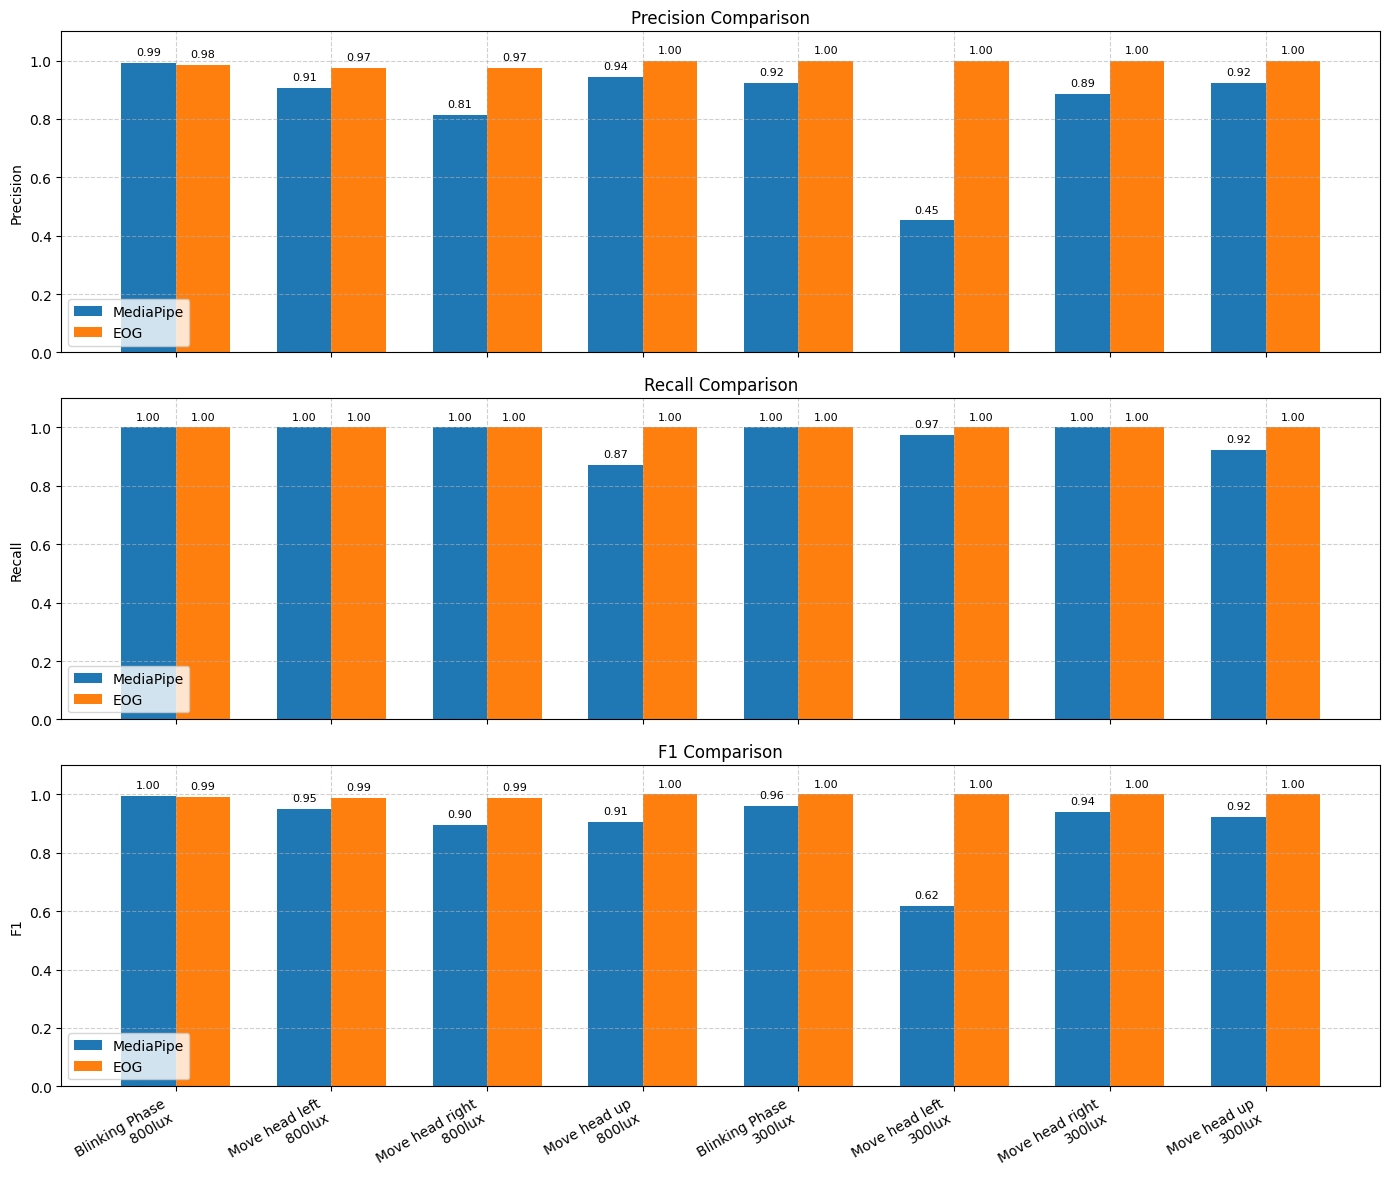

In [65]:
plot_evaluation_results(dorus_loaded_data["phase_results"])

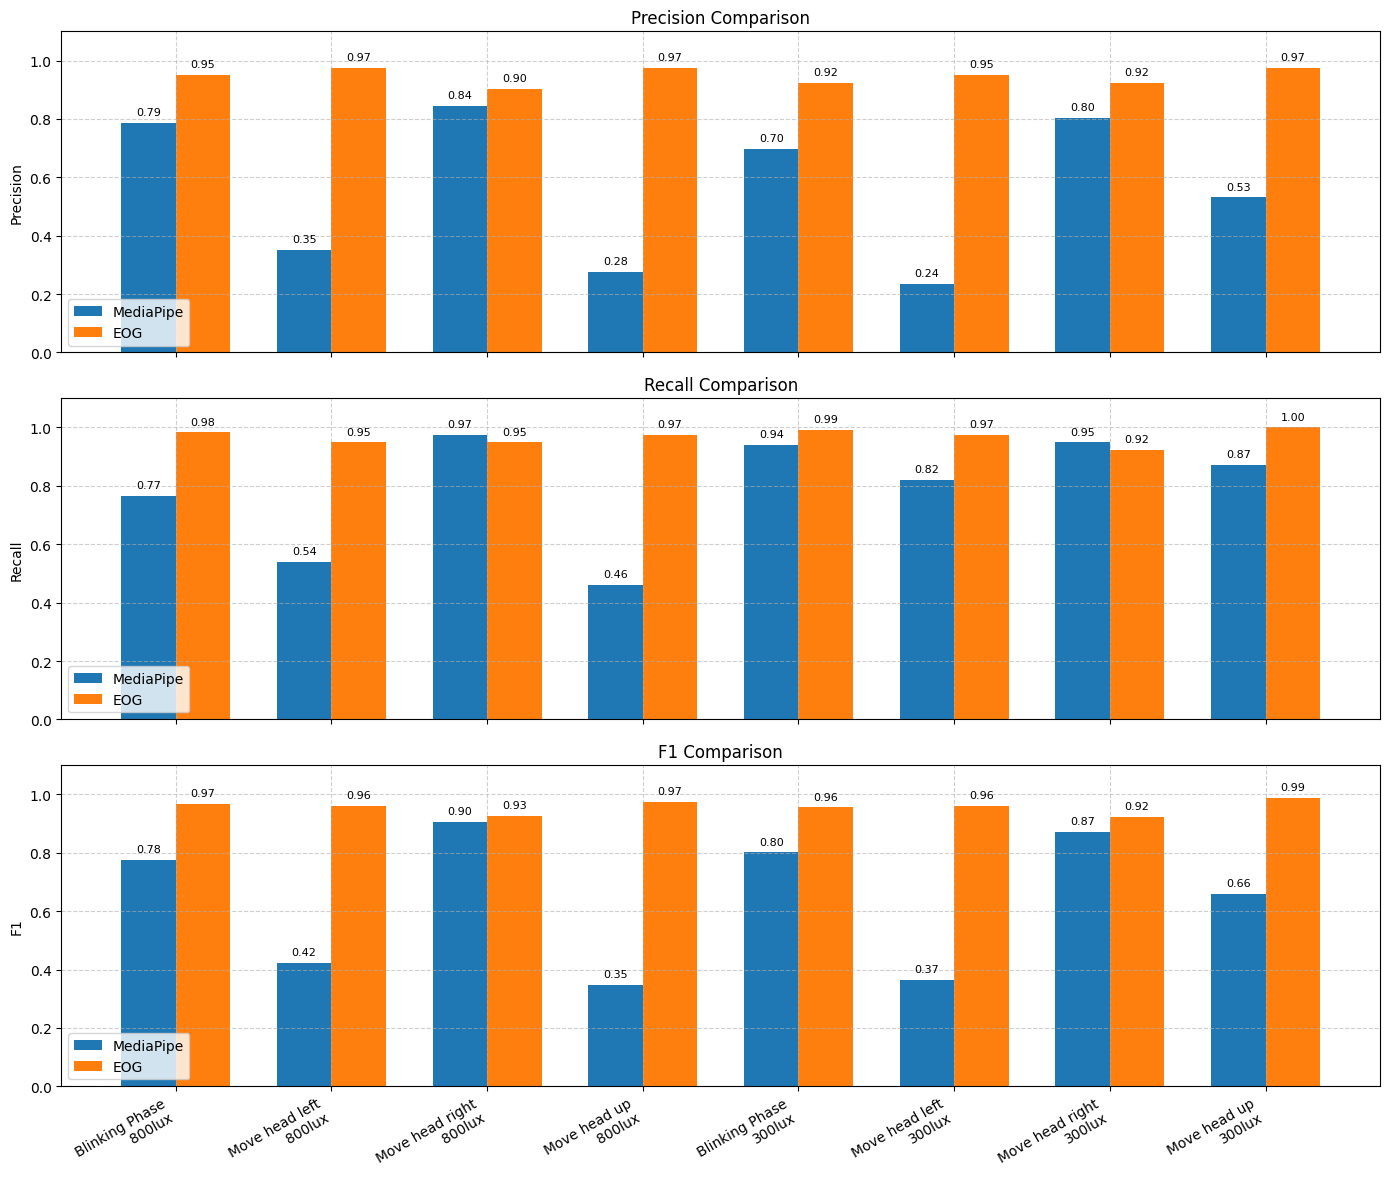

In [64]:
plot_evaluation_results(roland_loaded_data["phase_results"])

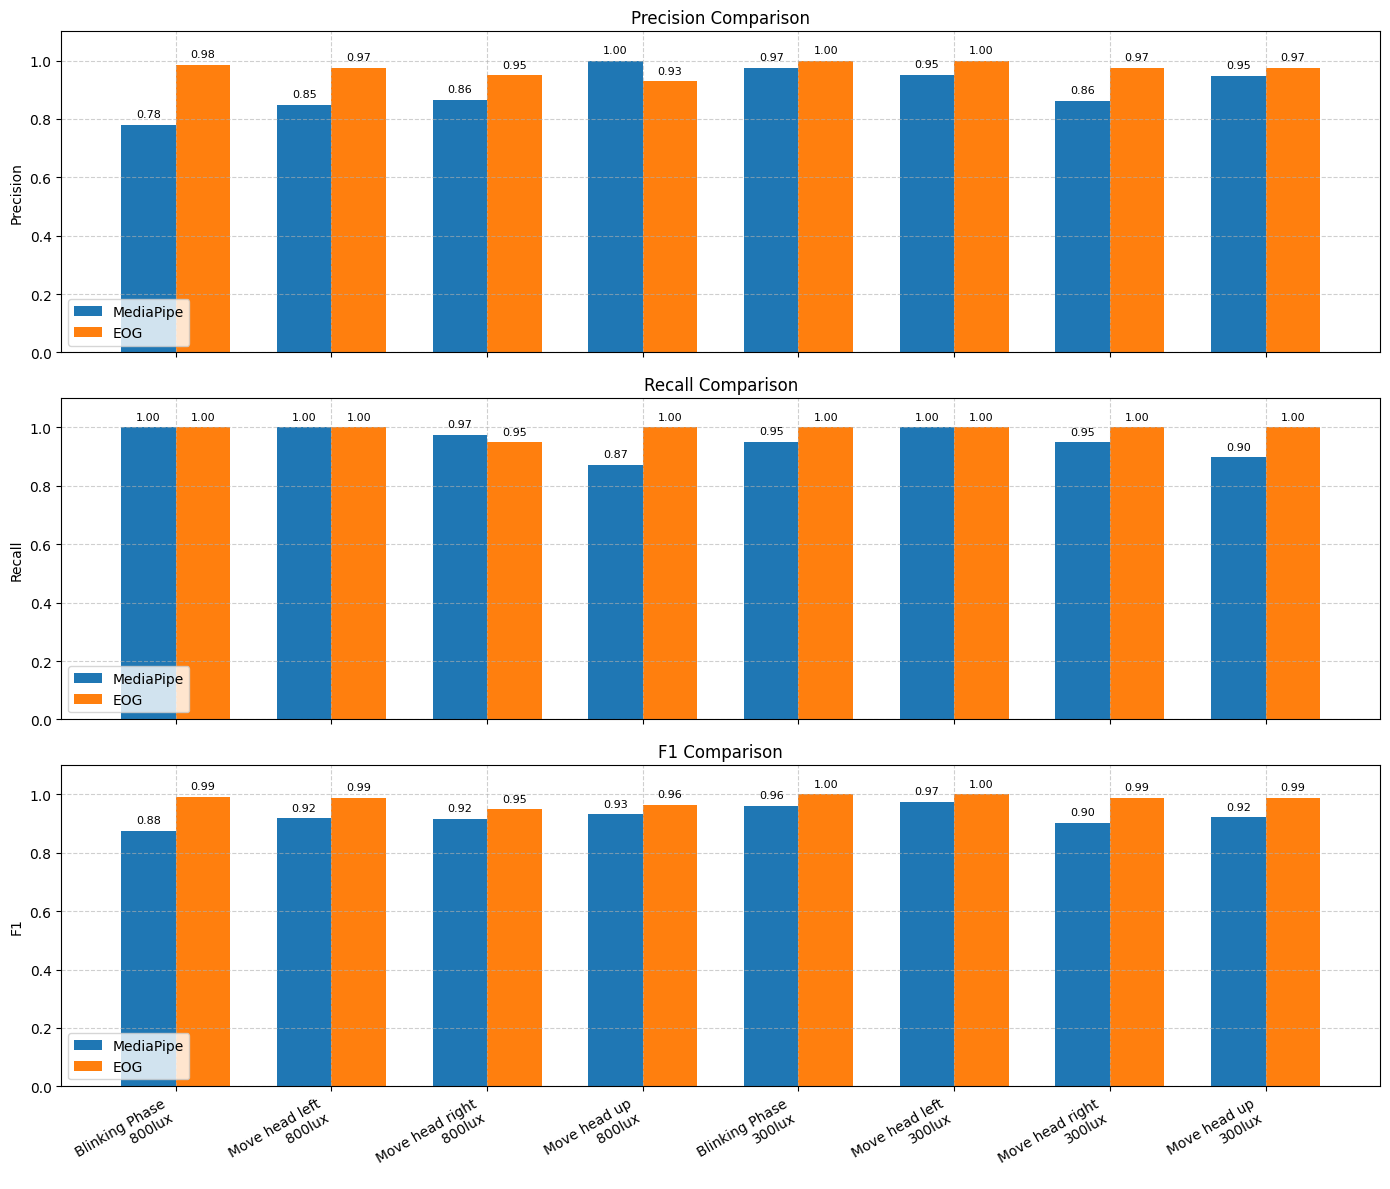

In [63]:
plot_evaluation_results(Gerick_loaded_data["phase_results"])

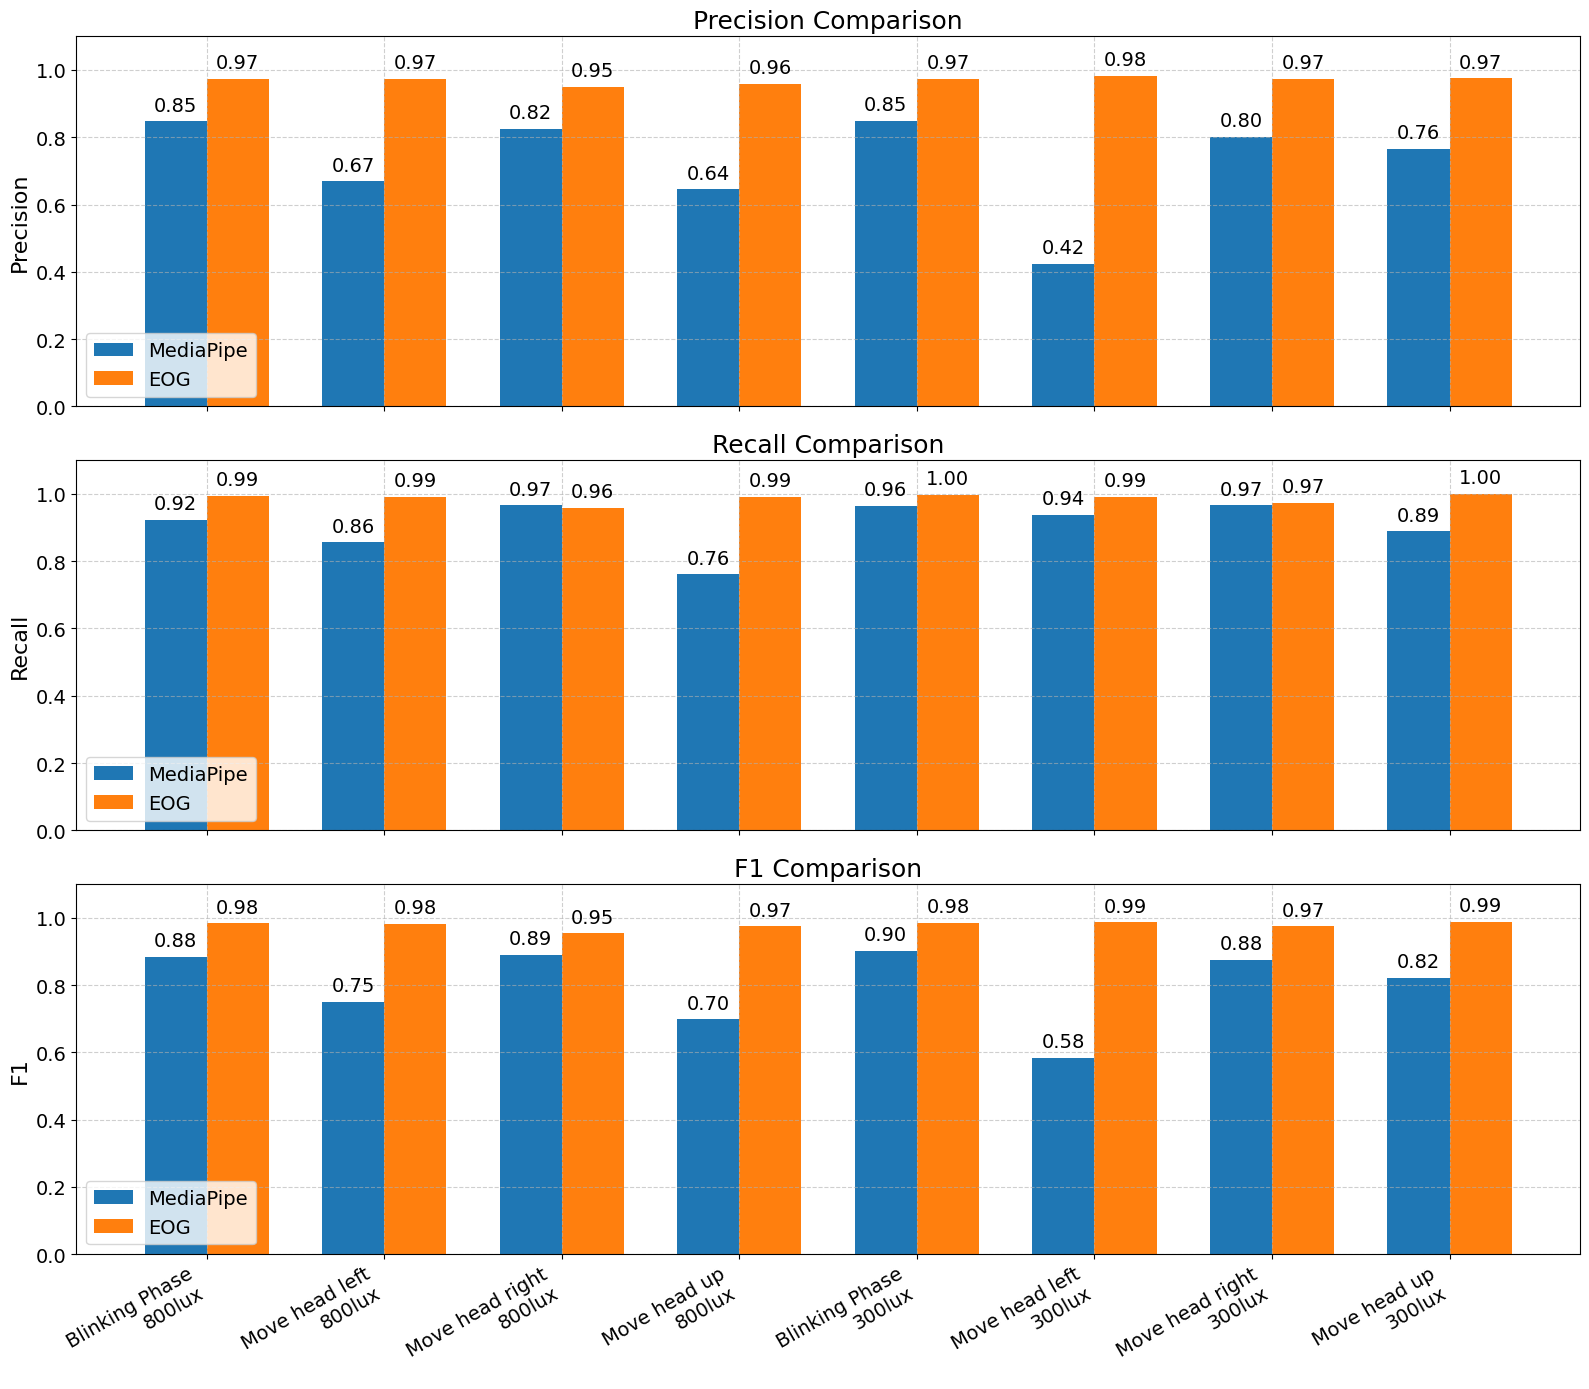

In [73]:
plot_evaluation_results(fused_phase_results)

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mediapipe_lighting_comparison_single_bar(phase_results):
    lux_levels = [300, 800]
    metrics = ['precision', 'recall', 'f1']
    colors = ['skyblue', 'lightgreen', 'salmon']
    method = 'mediapipe'
    task_name = 'Blinking Phase'

    # Gather data: for each lux, collect precision, recall, f1 in order
    data = []
    for lux in lux_levels:
        key = (task_name, lux)
        vals = [phase_results[key][f"{method}_{metric}"] for metric in metrics]
        data.append(vals)

    data = np.array(data)  # shape (2 lux_levels, 3 metrics)

    x = np.arange(len(lux_levels))  # positions for 300 and 800 lux
    width = 0.25  # width of each metric bar within group

    fig, ax = plt.subplots(figsize=(10,6))

    # Plot bars for each metric side by side per lux level
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        ax.bar(x + i*width - width, data[:, i], width, label=metric.capitalize(), color=color)

    ax.set_xticks(x)
    ax.set_xticklabels([f"{lux} lux" for lux in lux_levels])
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Score')
    ax.set_title('MediaPipe Performance by Lighting and Metric', fontsize=16)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    # Add value labels on top of bars
    for i in range(len(lux_levels)):
        for j in range(len(metrics)):
            ax.text(x[i] + j*width - width, data[i, j] + 0.02, f"{data[i, j]:.2f}", ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()


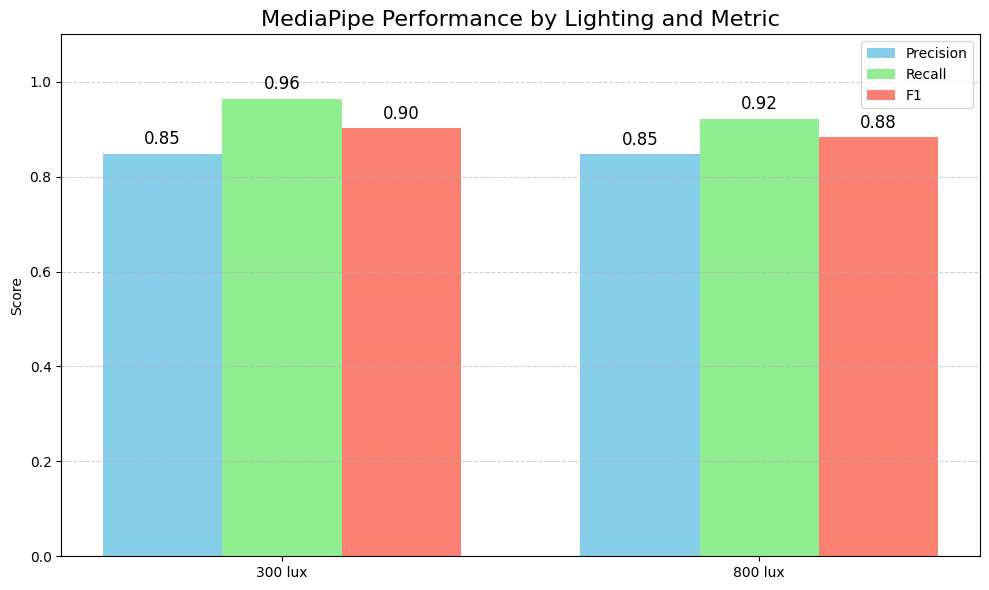

In [84]:
plot_mediapipe_lighting_comparison_single_bar(fused_phase_results)